# Test d'optimiseurs sur des benchmarks analytiques

Ce notebook permet de reproduire les résultats de ce papier:

Bensaid, B., Poëtte, G. & Turpault, R. Deterministic Neural Networks Optimization from a Continuous and Energy Point of View. J Sci Comput 96, 14 (2023). https://doi.org/10.1007/s10915-023-02215-4

Dans ce papier, nous avons mis au point des benchmarks analytiques dans le sens où nous les avons construit de manière à connaitre {\it a priori} les résultats d'apprentissage optimaux. Il est ainsi possible de comprendre les mécanismes d'apprentissage, les propriétés désirables et indésirables des optimiseurs et de tester de nouveaux sur la base d'expériences numériques rapides et fiables. 

In [2]:
# Import de quelques librairies utiles
from keras import optimizers
from keras import losses
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import os
import numpy as np
import matplotlib.pyplot as plt

# import de quelques librairies de Bilel Bensaid
import activations_perso
from model import build_poly
from training import train
import read

## Chargement des données d'entrainement: 

Pour ces benchmarks analytiques, il n'y a que $2$ points d'entrainement:
- cela rend les calculs des points critiques (i.e. des résultats désirables d'apprentissage) plus facile
- les temps de calculs des expériences numériques raisonnables. 

In [3]:
# batch_size=2 => optimiseur deterministe. batch_size=1 => optimiseur stochastique
batch_size=2

# Chargement des données d'entrainement 
x_train,y_train = read.poly_data()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=batch_size).batch(batch_size)


I0000 00:00:1729264935.457284  104665 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-18 17:22:15.458084: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Choix des fonctions d'activation et de la fonction de coût

Choix parmi:
- polyTwo: 4 minima, tous les minimas sont globaux, cas peu raide
- polyThree: 1 minimum global, 3 minima locaux, des points selles et des maxima, cas raide
- polyFive: ? .. ?

Toutes les informations sur ces cas-tests sont dans le papier précité ou dans le mémoire de Thèse de Bilel Bensaid

In [4]:
# Choix du cas analytique à étudier (parmi polyTwo, polyThree et polyFive)
activation=activations_perso.polyThree
# Ne pas en choisir d'autres (sinon pas de résultats analytiques)
loss = losses.MeanSquaredError()


# Paramètres de l'apprentissage

Choix de:
- du type d'initilisation (Uniform, Xavier, Bengio): Xavier et Bengio sont les plus utilisés dans la litérature. L'initialiseur uniforme l'est beaucoup moins. Pourquoi à votre avis? 

A noter que la graine (seed) est fixée, par souci de reproductibilité des résultats numériques (est ce toujours le cas dans les framework de ML classique?). 

In [19]:
# Graine
seed=0
# Initialiseur
name_init="Uniform"
w=-2; b=2
params_init=[w,w,b,b]

#paramètres d'arrêt
# sur l'annulation du gradient
eps=10**(-6)
# sur le nombre maximal d'epochs
max_epochs=300

#paramètres d'entrainement 
# learning rate (commun à tous les optimiseurs testables)
lr=0.1

# les autres paramètres sont utilisés ou ignorés en fonction du choix de l'optimiseur
# ?
seuil=0.01

# paramètres de LC_EGD
f1=30; f2=10000; lambd=0.5; rho=0.9; eps_egd=0.01

# paramètres pour Adam ou Momentum ou RMSprop etc. 
beta_1=0.9; beta_2=0.999; epsilon=1e-07
amsgrad=False

# Choix de l'optimiseur
algo="LC_EGD"
#algo="Adam"

# Apprentissage

In [24]:
model = build_poly(activation,loss,name_init,params_init,seed);
model_copy = build_poly(activation,loss,name_init,params_init,seed)

Nb_tirages = 60

WEIGHTS = []
WEIGHTS_INIT=[]
for it in range(Nb_tirages):
  # Nouvelle initialisation
  w = 6 * np.random.random() - 3
  b = 6 * np.random.random() - 3
  WEIGHTS_INIT.append([w,b])
  params_init = [w, w, b, b]
  # Début du modèle
  model = build_poly(activation,loss,name_init,params_init,seed);
  model_copy = build_poly(activation,loss,name_init,params_init,seed)
  # entrainement
  model, epoch, norme_grad, cost, temps = train(algo,model,model_copy,loss,x_train,y_train,eps,max_epochs,lr,seuil,f1,f2,rho,eps_egd,lambd,beta_1,beta_2,epsilon,amsgrad)
  print(it, model.get_weights())
  WEIGHTS.append(model.get_weights())
  print("temps: ", temps)

Model: "sequential_280"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_281"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_281 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_282"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_282 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_283"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_283 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(21.828744165449656, shape=(), dtype=float64)
grad_init:  tf.Tensor(107.56820976162679, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000016
grad:  tf.Tensor(0.002018430287018759, shape=(), dtype=float64)
lr:  45.121391085239736
dim:  tf.Tensor(-2.3271921278933405e-08, shape=(), dtype=float64)
top:  tf.Tensor(-9.191364586233115e-05, shape=(), dtype=float64)
Pb conditionnement
0 [array([[-1.99999989]]), array([0.9999999])]
temps:  3.1209375858306885


Model: "sequential_284"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_284 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_285"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(13777.216095415146, shape=(), dtype=float64)
grad_init:  tf.Tensor(26698.52031368899, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000273
grad:  tf.Tensor(0.009214967931641357, shape=(), dtype=float64)
lr:  45.121391085239686
dim:  tf.Tensor(-5.675923908654568e-07, shape=(), dtype=float64)
top:  tf.Tensor(-0.0019157557650579138, shape=(), dtype=float64)
1 [array([[-1.99999996]]), array([0.99999996])]
temps:  2.7114245891571045


Model: "sequential_286"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_286 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_287"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_287 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(409.7866297090164, shape=(), dtype=float64)
grad_init:  tf.Tensor(1617.5593082978835, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(0.00033954574808855856, shape=(), dtype=float64)
lr:  45.121391085239736
dim:  tf.Tensor(-6.567759669451334e-10, shape=(), dtype=float64)
top:  tf.Tensor(-2.6010522574389404e-06, shape=(), dtype=float64)
Pb conditionnement
2 [array([[-2.0000001]]), array([1.00000009])]
temps:  2.9575555324554443


Model: "sequential_288"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_288 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_289"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_289 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1419.5081554843246, shape=(), dtype=float64)
grad_init:  tf.Tensor(4401.898770170999, shape=(), dtype=float64)
3 [array([[-1.18225215e-08]]), array([-0.99999999])]
temps:  1.0142951011657715


Model: "sequential_290"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_290 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_291"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_291 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(17.932759317680215, shape=(), dtype=float64)
grad_init:  tf.Tensor(29.869803277832354, shape=(), dtype=float64)
4 [array([[6.92482678e-09]]), array([-1.])]
temps:  0.8818676471710205


Model: "sequential_292"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_292 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_293"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_293 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(13.215005368275971, shape=(), dtype=float64)
grad_init:  tf.Tensor(44.063555579844746, shape=(), dtype=float64)
5 [array([[-8.2909012e-09]]), array([-1.])]
temps:  0.7585015296936035


Model: "sequential_294"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_294 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_295"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_295 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(14.967877277592846, shape=(), dtype=float64)
grad_init:  tf.Tensor(54.3397816165888, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000002
grad:  tf.Tensor(0.0007761947616325815, shape=(), dtype=float64)
lr:  45.12139108523966
dim:  tf.Tensor(-3.6114808921183794e-09, shape=(), dtype=float64)
top:  tf.Tensor(-1.3592329677501728e-05, shape=(), dtype=float64)
Pb conditionnement
6 [array([[-1.99999991]]), array([0.99999993])]
temps:  3.002742052078247


Model: "sequential_296"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_296 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_297"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(464.58913390924766, shape=(), dtype=float64)
grad_init:  tf.Tensor(1156.0605540607792, shape=(), dtype=float64)
7 [array([[1.16060755e-08]]), array([-1.00000001])]
temps:  1.2136354446411133


Model: "sequential_298"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_298 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_299"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_299 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(20.8956010588806, shape=(), dtype=float64)
grad_init:  tf.Tensor(4.075143821114292, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(0.0006231768659647115, shape=(), dtype=float64)
lr:  1.5040463695079909
dim:  tf.Tensor(-6.17461637375527e-11, shape=(), dtype=float64)
top:  tf.Tensor(-2.9204775730319596e-07, shape=(), dtype=float64)
Pb conditionnement
8 [array([[-1.99999992]]), array([0.99999993])]
temps:  2.910484790802002


Model: "sequential_300"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_301"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_301 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(8.319452107880334, shape=(), dtype=float64)
grad_init:  tf.Tensor(59.134875435762524, shape=(), dtype=float64)
9 [array([[-1.33889944e-08]]), array([-0.99999999])]
temps:  0.7408785820007324


Model: "sequential_302"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_302 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_303"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_303 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(418.61661661252685, shape=(), dtype=float64)
grad_init:  tf.Tensor(1404.1021887985085, shape=(), dtype=float64)
10 [array([[1.0637971e-08]]), array([-1.00000001])]
temps:  0.8563175201416016


Model: "sequential_304"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_304 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_305"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_305 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(29.40211125891439, shape=(), dtype=float64)
grad_init:  tf.Tensor(39.55040147091053, shape=(), dtype=float64)
11 [array([[-2.33608974e-08]]), array([1.00000002])]
temps:  0.7289290428161621


Model: "sequential_306"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_306 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_307 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(404.4300057433338, shape=(), dtype=float64)
grad_init:  tf.Tensor(908.235725548543, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000001
grad:  tf.Tensor(0.0004644254931305633, shape=(), dtype=float64)
lr:  45.121391085239736
dim:  tf.Tensor(-1.2354401945913196e-09, shape=(), dtype=float64)
top:  tf.Tensor(-4.866139854695548e-06, shape=(), dtype=float64)
Pb conditionnement
12 [array([[-2.00000008]]), array([1.00000007])]
temps:  2.8754618167877197


Model: "sequential_308"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_308 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_309"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_309 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(3247.5391083236054, shape=(), dtype=float64)
grad_init:  tf.Tensor(7915.040800455547, shape=(), dtype=float64)
13 [array([[7.09367985e-09]]), array([-1.])]
temps:  0.9628016948699951


Model: "sequential_310"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_310 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_311"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_311 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(214.86979130494163, shape=(), dtype=float64)
grad_init:  tf.Tensor(716.6483617336389, shape=(), dtype=float64)
14 [array([[1.99999998]]), array([-0.99999999])]
temps:  0.8506283760070801


Model: "sequential_312"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_312 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_313"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_313 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(20.40423216645028, shape=(), dtype=float64)
grad_init:  tf.Tensor(4.196726866812642, shape=(), dtype=float64)
15 [array([[1.69812283e-08]]), array([0.99999999])]
temps:  0.7167189121246338


Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_314 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1948.200201022104, shape=(), dtype=float64)
grad_init:  tf.Tensor(5092.180258972189, shape=(), dtype=float64)
Pb conditionnement
16 [array([[9.12440417e-08]]), array([0.99999994])]
temps:  1.4530720710754395


Model: "sequential_316"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_316 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_317 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(9195.280094885622, shape=(), dtype=float64)
grad_init:  tf.Tensor(18988.066520563625, shape=(), dtype=float64)
Pb conditionnement
17 [array([[3.49720719e-08]]), array([1.])]
temps:  1.5310301780700684


Model: "sequential_318"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_318 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_319"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_319 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1.2516504420100034, shape=(), dtype=float64)
grad_init:  tf.Tensor(22.09017807623121, shape=(), dtype=float64)
18 [array([[-7.31324982e-09]]), array([-0.99999999])]
temps:  0.74418044090271


Model: "sequential_320"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_320 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_321"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_321 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(20.21060436114563, shape=(), dtype=float64)
grad_init:  tf.Tensor(9.758880206076878, shape=(), dtype=float64)
19 [array([[1.23592902e-08]]), array([-1.00000001])]
temps:  0.8458235263824463


Model: "sequential_322"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_322 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_323"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_323 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(129.60233948561543, shape=(), dtype=float64)
grad_init:  tf.Tensor(441.0160554419225, shape=(), dtype=float64)
20 [array([[1.99999997]]), array([-1.])]
temps:  0.9820027351379395


Model: "sequential_324"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_324 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_325"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_325 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(89.7317632238537, shape=(), dtype=float64)
grad_init:  tf.Tensor(231.66987252483483, shape=(), dtype=float64)
21 [array([[-3.56292615e-09]]), array([-1.])]
temps:  1.2461292743682861


Model: "sequential_326"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_326 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_327"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_327 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(19.85482643304892, shape=(), dtype=float64)
grad_init:  tf.Tensor(17.56185276864398, shape=(), dtype=float64)
22 [array([[6.03093809e-09]]), array([-1.])]
temps:  0.8517355918884277


Model: "sequential_328"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_328 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_329"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_329 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(15.738554762641481, shape=(), dtype=float64)
grad_init:  tf.Tensor(22.842577739620268, shape=(), dtype=float64)
23 [array([[8.0461049e-09]]), array([-1.00000001])]
temps:  0.7734158039093018


Model: "sequential_330"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_331"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_331 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(20.659277175705455, shape=(), dtype=float64)
grad_init:  tf.Tensor(4.251938719563311, shape=(), dtype=float64)
24 [array([[-8.61178421e-09]]), array([-0.99999999])]
temps:  0.845189094543457


Model: "sequential_332"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_332 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_333 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(18.347804134255153, shape=(), dtype=float64)
grad_init:  tf.Tensor(53.66220746960314, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(0.00011452252662800081, shape=(), dtype=float64)
lr:  45.12139108523966
dim:  tf.Tensor(-7.437250815200969e-11, shape=(), dtype=float64)
top:  tf.Tensor(-2.9589275174070084e-07, shape=(), dtype=float64)
25 [array([[-2.00000005]]), array([1.00000004])]
temps:  2.125330686569214


Model: "sequential_334"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_334 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_335 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(66.13273852338146, shape=(), dtype=float64)
grad_init:  tf.Tensor(373.99185927403465, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(0.0004644352435395121, shape=(), dtype=float64)
lr:  1.5040463695079909
dim:  tf.Tensor(-3.430855599617644e-11, shape=(), dtype=float64)
top:  tf.Tensor(-1.6221147272573723e-07, shape=(), dtype=float64)
Pb conditionnement
26 [array([[-1.99999986]]), array([0.99999988])]
temps:  2.8005027770996094


Model: "sequential_336"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_336 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_337"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_337 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(38.72012532580812, shape=(), dtype=float64)
grad_init:  tf.Tensor(75.70172145362727, shape=(), dtype=float64)
Pb conditionnement
27 [array([[1.99999998]]), array([-1.])]
temps:  1.9059052467346191


Model: "sequential_338"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_338 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_339 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(16215.937026667016, shape=(), dtype=float64)
grad_init:  tf.Tensor(31696.044506195693, shape=(), dtype=float64)
28 [array([[-9.09555131e-09]]), array([-0.99999999])]
temps:  1.0148437023162842


Model: "sequential_340"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_341"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_341 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(263.78447613862613, shape=(), dtype=float64)
grad_init:  tf.Tensor(623.0293568427601, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(7.826512099057259e-05, shape=(), dtype=float64)
lr:  1.5040463695079893
dim:  tf.Tensor(-9.734435479913373e-13, shape=(), dtype=float64)
top:  tf.Tensor(-4.606464747647335e-09, shape=(), dtype=float64)
29 [array([[-2.00000006]]), array([1.00000005])]
temps:  2.054344892501831


Model: "sequential_342"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_342 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_343"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_343 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(335.75421799130015, shape=(), dtype=float64)
grad_init:  tf.Tensor(1087.4466949033576, shape=(), dtype=float64)
Pb conditionnement
30 [array([[1.99999995]]), array([-1.])]
temps:  1.6154186725616455


Model: "sequential_344"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_344 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_345"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_345 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(9.266567531034926, shape=(), dtype=float64)
grad_init:  tf.Tensor(7.227910229032079, shape=(), dtype=float64)
Pb conditionnement
31 [array([[1.99999995]]), array([-0.99999997])]
temps:  1.4720945358276367


Model: "sequential_346"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_346 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_347"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_347 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1314.7119359584174, shape=(), dtype=float64)
grad_init:  tf.Tensor(4146.468624461717, shape=(), dtype=float64)
32 [array([[-5.37429873e-09]]), array([-1.])]
temps:  0.902777910232544


Model: "sequential_348"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_348 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_349"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_349 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(23.558511190575704, shape=(), dtype=float64)
grad_init:  tf.Tensor(47.41321348563748, shape=(), dtype=float64)
33 [array([[5.05358283e-08]]), array([0.99999996])]
temps:  0.8142757415771484


Model: "sequential_350"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_351"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_351 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1349.8193519873425, shape=(), dtype=float64)
grad_init:  tf.Tensor(3738.2163904891754, shape=(), dtype=float64)
34 [array([[-1.14431293e-08]]), array([-0.99999999])]
temps:  1.027773141860962


Model: "sequential_352"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_352 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_353"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_353 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(51.74388603494707, shape=(), dtype=float64)
grad_init:  tf.Tensor(285.5110223487114, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000007
grad:  tf.Tensor(0.0023488336126323856, shape=(), dtype=float64)
lr:  1.5040463695079909
dim:  tf.Tensor(-8.751843694199124e-10, shape=(), dtype=float64)
top:  tf.Tensor(-4.148926454289623e-06, shape=(), dtype=float64)
Pb conditionnement
35 [array([[-1.99999994]]), array([0.99999993])]
temps:  2.990452766418457


Model: "sequential_354"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_354 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_355"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_355 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(1903.382412778888, shape=(), dtype=float64)
grad_init:  tf.Tensor(5504.477655118602, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(3.6146458828883906e-05, shape=(), dtype=float64)
lr:  45.121391085239736
dim:  tf.Tensor(-7.30082660993503e-12, shape=(), dtype=float64)
top:  tf.Tensor(-2.947704869386319e-08, shape=(), dtype=float64)
Pb conditionnement
36 [array([[-2.0000001]]), array([1.00000011])]
temps:  2.499422788619995


Model: "sequential_356"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_356 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_357"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_357 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(6.552906837398989, shape=(), dtype=float64)
grad_init:  tf.Tensor(24.13150132491994, shape=(), dtype=float64)
37 [array([[1.18543468e-08]]), array([-1.00000001])]
temps:  0.776947021484375


Model: "sequential_358"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_358 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_359 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(37.61959443805659, shape=(), dtype=float64)
grad_init:  tf.Tensor(91.45473497907278, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(6.493810523386624e-05, shape=(), dtype=float64)
lr:  45.121391085239715
dim:  tf.Tensor(-2.5474733433838992e-11, shape=(), dtype=float64)
top:  tf.Tensor(-9.51374945300626e-08, shape=(), dtype=float64)
Pb conditionnement
38 [array([[-2.00000009]]), array([1.00000008])]
temps:  2.5881614685058594


Model: "sequential_360"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_360 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_361"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_361 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(10559.222067627832, shape=(), dtype=float64)
grad_init:  tf.Tensor(22042.047942445446, shape=(), dtype=float64)
39 [array([[9.27794737e-09]]), array([-1.00000001])]
temps:  0.9310195446014404


Model: "sequential_362"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_362 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_363"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_363 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(5078.226118359034, shape=(), dtype=float64)
grad_init:  tf.Tensor(12167.823295375127, shape=(), dtype=float64)
40 [array([[2.1940525e-09]]), array([-1.])]
temps:  0.8949055671691895


Model: "sequential_364"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_364 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_365"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_365 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(25562.745112798162, shape=(), dtype=float64)
grad_init:  tf.Tensor(44819.7446113202, shape=(), dtype=float64)
41 [array([[6.24334294e-08]]), array([0.99999995])]
temps:  0.9202530384063721


Model: "sequential_366"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_366 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_367"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_367 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(460.45317546129706, shape=(), dtype=float64)
grad_init:  tf.Tensor(1820.4414973516502, shape=(), dtype=float64)
42 [array([[-3.85591618e-09]]), array([-1.])]
temps:  0.9247994422912598


Model: "sequential_368"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_368 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_369"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_369 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(28.934577431989666, shape=(), dtype=float64)
grad_init:  tf.Tensor(47.873550739749696, shape=(), dtype=float64)
Pb conditionnement
43 [array([[1.99999994]]), array([-0.99999999])]
temps:  1.8135466575622559


Model: "sequential_370"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_371"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(129.67959835968568, shape=(), dtype=float64)
grad_init:  tf.Tensor(641.4300462877162, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000000
grad:  tf.Tensor(0.00019068286908775393, shape=(), dtype=float64)
lr:  1.5040463695079915
dim:  tf.Tensor(-5.778488798569015e-12, shape=(), dtype=float64)
top:  tf.Tensor(-2.7343530332428422e-08, shape=(), dtype=float64)
Pb conditionnement
44 [array([[-1.99999991]]), array([0.99999991])]
temps:  2.731367349624634


Model: "sequential_372"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_372 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_373 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(552.8707380136314, shape=(), dtype=float64)
grad_init:  tf.Tensor(1520.5629098040904, shape=(), dtype=float64)
45 [array([[7.24913411e-09]]), array([-1.00000001])]
temps:  1.009748935699463


Model: "sequential_374"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_374 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_375"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_375 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(132.81868651785362, shape=(), dtype=float64)
grad_init:  tf.Tensor(464.73351418195233, shape=(), dtype=float64)
Pb conditionnement
46 [array([[2.00000003]]), array([-1.])]
temps:  1.5774750709533691


Model: "sequential_376"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_376 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_377"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_377 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(15.800799619241626, shape=(), dtype=float64)
grad_init:  tf.Tensor(107.5836593148162, shape=(), dtype=float64)
47 [array([[-6.16211829e-09]]), array([-1.])]
temps:  0.8772692680358887


Model: "sequential_378"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_378 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_379"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_379 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(18.401866118482015, shape=(), dtype=float64)
grad_init:  tf.Tensor(12.75699033936735, shape=(), dtype=float64)
48 [array([[1.99999997]]), array([-0.99999999])]
temps:  0.8595120906829834


Model: "sequential_380"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_380 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_381"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_381 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(28.850996346235505, shape=(), dtype=float64)
grad_init:  tf.Tensor(49.79093727979374, shape=(), dtype=float64)
Pb conditionnement
49 [array([[1.9999999]]), array([-1.00000001])]
temps:  1.5053510665893555


Model: "sequential_382"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_382 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_383"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_383 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(818.2533717817369, shape=(), dtype=float64)
grad_init:  tf.Tensor(2705.221843379253, shape=(), dtype=float64)
50 [array([[3.35215504e-09]]), array([-1.])]
temps:  0.9435031414031982


Model: "sequential_384"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_384 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_385"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(77.13464960245416, shape=(), dtype=float64)
grad_init:  tf.Tensor(215.8599276440013, shape=(), dtype=float64)
51 [array([[-5.29151117e-08]]), array([1.00000003])]
temps:  0.7910275459289551


Model: "sequential_386"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_386 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_387"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_387 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(4648.000040967708, shape=(), dtype=float64)
grad_init:  tf.Tensor(11090.488376276697, shape=(), dtype=float64)
52 [array([[5.78953434e-09]]), array([-1.])]
temps:  0.9267451763153076


Model: "sequential_388"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_388 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_389"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_389 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(3006.968264662155, shape=(), dtype=float64)
grad_init:  tf.Tensor(8046.933490629282, shape=(), dtype=float64)
53 [array([[-8.37790481e-09]]), array([-0.99999999])]
temps:  1.0024409294128418


Model: "sequential_390"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_390 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_391"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_391 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(9351.146632265345, shape=(), dtype=float64)
grad_init:  tf.Tensor(20127.209507064952, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000273
grad:  tf.Tensor(0.008457064490603402, shape=(), dtype=float64)
lr:  45.1213910852397
dim:  tf.Tensor(-4.096781012208339e-07, shape=(), dtype=float64)
top:  tf.Tensor(-0.0016135847084053395, shape=(), dtype=float64)
Pb conditionnement
54 [array([[-1.99999991]]), array([0.9999999])]
temps:  3.2524375915527344


Model: "sequential_392"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_392 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_393"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_393 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(20.34590383849828, shape=(), dtype=float64)
grad_init:  tf.Tensor(3.354370432417659, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000030
grad:  tf.Tensor(0.005066116162046618, shape=(), dtype=float64)
lr:  1.5040463695079909
dim:  tf.Tensor(-4.075413784221382e-09, shape=(), dtype=float64)
top:  tf.Tensor(-1.9301075840515177e-05, shape=(), dtype=float64)
Pb conditionnement
55 [array([[-1.99999992]]), array([0.99999992])]
temps:  3.099100112915039


Model: "sequential_394"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_394 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_395"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_395 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(18.43812177065189, shape=(), dtype=float64)
grad_init:  tf.Tensor(7.88652817184007, shape=(), dtype=float64)
56 [array([[1.2751319e-08]]), array([-1.00000001])]
temps:  0.8336515426635742


Model: "sequential_396"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_396 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_397"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_397 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(23.815860974519325, shape=(), dtype=float64)
grad_init:  tf.Tensor(14.680846775425886, shape=(), dtype=float64)
57 [array([[-7.47866507e-10]]), array([-1.])]
temps:  0.9052677154541016


Model: "sequential_398"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_398 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_399"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_399 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(23.69044321546479, shape=(), dtype=float64)
grad_init:  tf.Tensor(5.235531814732808, shape=(), dtype=float64)
58 [array([[1.3776531e-08]]), array([-1.00000001])]
temps:  0.8794472217559814


Model: "sequential_400"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_400 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_401"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_401 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (16.00 B)

 Trainable params: 2 (16.00 B)

 Non-trainable params: 0 (0.00 B)

cost_init:  tf.Tensor(371.66117201870725, shape=(), dtype=float64)
grad_init:  tf.Tensor(1211.0517928175755, shape=(), dtype=float64)

Start of epoch 100
Training loss (for one batch) at epoch 100: 8.00000001
grad:  tf.Tensor(0.0004554574349898036, shape=(), dtype=float64)
lr:  45.12139108523974
dim:  tf.Tensor(-1.252120185313288e-09, shape=(), dtype=float64)
top:  tf.Tensor(-4.680023962360853e-06, shape=(), dtype=float64)
Pb conditionnement
59 [array([[-2.00000007]]), array([1.00000007])]
temps:  2.926945924758911


# Tri des types de points critiques obtenus

In [25]:
# Pour polyThree
glob=[[0,-1]]
loca=[[-2,1],[2,-1],[0,1]]
sadd=[[-1,0],[1,0],[-1,1],[1,-1]]

# Pour classer les points
seuil_acceptation=1.e-4

# Construction du code couleur
res=[]
i=0
for w in WEIGHTS:
  #print(w, w[0][0][0],w[1][0])
  Wl = np.array([w[0][0][0],w[1][0]])
  #print(Wl)
  for g in glob:
    #print(Wl, g, np.linalg.norm(Wl-g))
    if np.linalg.norm(Wl-g) < seuil_acceptation:
      res.append(0)
      print("GLOBAL")
      break
  for l in loca:
    #print(Wl, l,np.linalg.norm(Wl-l)[0])
    if np.linalg.norm(Wl-l) < seuil_acceptation:
      res.append(1)
      print("LOCAL")
      break
  for s in sadd:
    #print(Wl, s,np.linalg.norm(Wl-s)[0])
    if np.linalg.norm(Wl-s) < seuil_acceptation:
      res.append(2)
      print("SADDLE")
      break
  if len(res) < i:
    res.append(4)
  i+=1



LOCAL
LOCAL
LOCAL
GLOBAL
GLOBAL
GLOBAL
LOCAL
GLOBAL
LOCAL
GLOBAL
GLOBAL
LOCAL
LOCAL
GLOBAL
LOCAL
LOCAL
LOCAL
LOCAL
GLOBAL
GLOBAL
LOCAL
GLOBAL
GLOBAL
GLOBAL
GLOBAL
LOCAL
LOCAL
LOCAL
GLOBAL
LOCAL
LOCAL
LOCAL
GLOBAL
LOCAL
GLOBAL
LOCAL
LOCAL
GLOBAL
LOCAL
GLOBAL
GLOBAL
LOCAL
GLOBAL
LOCAL
LOCAL
GLOBAL
LOCAL
GLOBAL
LOCAL
LOCAL
GLOBAL
LOCAL
GLOBAL
GLOBAL
LOCAL
LOCAL
GLOBAL
GLOBAL
GLOBAL
LOCAL


# Affichage sur la carte de sensibilité

[-1.228255444080464, -0.06449170123230186]
[2.111356980555211, 2.753320653191433]
[-2.841917952935527, 0.7024879551069496]
[-1.3804170962580578, -1.267062775551538]
[0.3371849347127114, -0.5815035860900148]


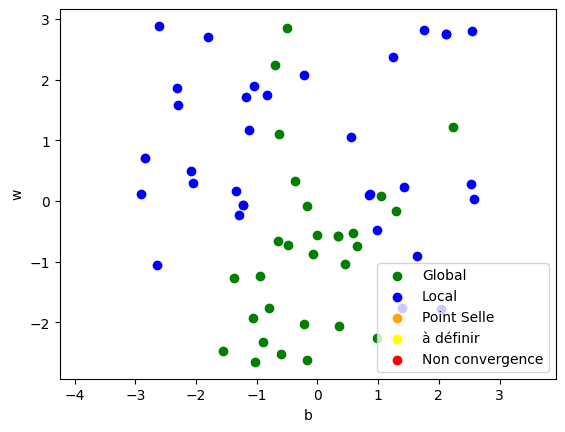

In [27]:
code=["green", "blue", "orange", "yellow", "red"]
sign=["Global", "Local", "Point Selle", "à définir", "Non convergence"]
for i in range(len(sign)):
  print(WEIGHTS_INIT[i])
  plt.scatter(WEIGHTS_INIT[i][0], WEIGHTS_INIT[i][1],color=code[i], label=sign[i])
for i in range(Nb_tirages-1):
  plt.scatter(WEIGHTS_INIT[i][0], WEIGHTS_INIT[i][1],color=code[res[i]])
plt.legend()
plt.xlabel("b")
plt.ylabel("w")
plt.axis('equal')
plt.show()